# Gas Storage Extrinsic Value Optimization With Swing Option Algorithm





## 1 - Preliminary introduction

A **gas storage** asset is a physical underground complex that can contain a large volume of natural gas. It is typically injected in the summer (april to october) and withdrawn in the winter (november to march) when gas supply is lacking. 

The **intrinsic value** of this asset is contained in the summer/winter spread on the forward markets. We will not cover this topic in this paper. We assume the intrinsic value is already hedged with forward products: Summer vs. march.

The **extrinsic value** is what we want to optimize. During winter phase, each time the spot price (ie: Day-Ahead contract) would be higher than march forward price, we have the possibility to modify the withdrawal trajectory of the storage asset: withdraw on day-ahead one part of the volume rather than in March, which translated on the markets means selling Day-Ahead and buying March contracts.

**Swing options** are exactly like American options except it allows the holder multiple exercise rights during the contract. The maximum capacity of our storage asset allows us to withdraw the whole volume of gas in 20 days. One winter has approximately 80 trading days where we can exercise one (and only one) right. We can therefore consider our storage asset as a swing option of N = 20 exercise rights, underlying = Day-Ahead price and strike = March price.

Our Spot and Forward price model will follow a **two-factor model** such as Clewlow and Strickland that allows us to catch different volatilities for different maturities. All the data provided come from ICE or Powernext and we will only deal with the TTF market (most liquid european gas market).

### Loading packages

First we need to load Python packages for this project. We will here only use basic yet powerful packages: numpy and pandas for calculations and algorithms, and matplotlib for ploting graphs.

Additionally, in an effort to allow the reader to reproduce our results, we arbitrarily set numpy random seeds to 100.

In [1]:
import os
# Prevents using GPU, in order to reproduce results
os.environ['CUDA_VISIBLE_DEVICES'] = ''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set seed value
seed = 100
# Set numpy random seed
np.random.seed(seed)


## 2 - Price model: two-factor price model

We will first describe step by step the process of our Monte-Carlo Price simulation.

In bond pricing applications instead of modelling via spot models the forward rates are specified. Clewlow and Strickland propose a similar approach for energy markets which relies on taking a forward curve and simulating how this forward curve will evolve through time. We will look specifically at a two factor mean-reverting forward curve case with volatility functions as defined by Clewlow and Strickland.

The Stochastic Differential Equation describing the process followed by the unitary forward curve F(t, T) is:

$$ \frac{dF(t,T)}{F(t,T)} = \sigma_s e^{-a(T-t)} dz_s + \sigma_l dz_l   $$

with mean reversion speed a, short-term volatility σs and long-term volatility σl and where zs and zl are Brownian Motions with no correlation.

We will not go into more details on the model, we suggest to curious readers to refer to this well-explained and detailed paper [1]


#### Data used for this study

All the data provided come from ICE market data (open source) and contains only TTF market data (most liquid european gas market). Data has been reorganized by ourselves for a better understanding. We have collected 10 years of historical data stored in separated csv files.


#### Construction of the DA / March spread

This idea of this chapter is to model the Day-Ahead (DA) / March spread prices through Monte-Carlo simulations.

The DA model is essentially the same as the forward model but the observation date is the same as the delivery date, i.e. instant delivery, T = t. We will be implementing the model for a daily granularity, with daily delivery period.

It is important to understand that both the forward contracts prices and the DA prices will be simulated by the same series of random variables. 

In [2]:
# Let's take 2017 as an example
n_year = 2017

In [5]:
# Last trading date
dt_end = str(n_year+1) + '-02-29'
    
# Loading DA data from csv
df_DA_prices = pd.read_csv('Project - data/' + str(n_year) + '_DA.csv',  index_col = 0)
df_DA_prices.index.name = 'dt_trading'

# Loading curve data from csv
df_curve_prices = pd.read_csv('Project - data/' + str(n_year) + '_curve.csv',  index_col = 0).loc[:dt_end]

To explicitly understand the construction of the forward curve, let us show the process through an example: we will take trading day as of '2017-11-15'

The curve prices are given by the market data that shows a price for each forward months. We only keep the 4 next months here, because we only need the curve until March contract.

The Day-Ahead curve was previously built with python package 'curves' that needs C++ compilation. The function optimize the trajectory of future Day-Ahead contracts by minimizing the slopes with the constraints of having the mean of Day-Ahead contracts within one month must equal the forward month contract price.
The idea is that this DA 'curve' is not realized yet, it is the most probable DA prices determined on a specific trading day.


In [6]:
dt_trade = '2017-11-15'  # as an example

da_curve = df_DA_prices[dt_trade].dropna()
curve = df_curve_prices.loc[dt_trade].iloc[:4]

Let's show what data is inside these pandas series, and then plot these series to understand the construction of the future spot price (day-ahead price).

In [7]:
da_curve.head(4)

dt_trading
2017-11-16    19.076000
2017-11-17    19.062822
2017-11-20    19.024077
2017-11-21    19.011660
Name: 2017-11-15, dtype: float64

In [8]:
curve

Dec 17    18.895
Jan 18    19.013
Feb 18    18.993
Mar 18    18.688
Name: 2017-11-15, dtype: float64

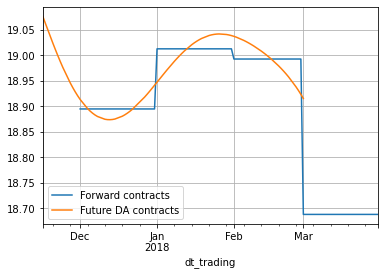

In [9]:
# Reading and ploting the data

# Forward Curve
curve_plot = pd.DataFrame(curve)
curve_plot.index = pd.PeriodIndex(pd.to_datetime(curve_plot.index, format= '%b %y'), freq='M')
curve_plot = curve_plot.resample('1D').pad()

# DA 'most probable' curve
da_curve_plot = pd.DataFrame(da_curve)
da_curve_plot.index = pd.PeriodIndex(pd.to_datetime(da_curve_plot.index, format= '%Y-%m-%d'), freq='D')

# ploting graph
fig, ax = plt.subplots()
curve_plot.plot(ax=ax)
da_curve_plot.plot(ax=ax)
ax.legend(['Forward contracts', 'Future DA contracts']);
plt.grid()
plt.show()

In [1], there is a whole explanation about volatility parameters calibration. It is usually calculated with historical volatility or implied volatility. For simplicity reasons, we will keep these parameters static in this paper. We arbitrarily chose mean values for these parameters, as shown below.

In [10]:
vol_s = 0.5    # sigma_s
vol_l = 0.1    # sigma_l
a = 1.5        # a

Now we can start the Monte-Carlo simulation with all the parameters set before. We can first initialize the variables.
We assume we need 1000 random trajectories to get relevant results.

In [11]:
# dimensions
nDays = len(df_curve_prices.loc[dt_trade:dt_end])
nMaturities = len(curve)
nSims = 1000

In [12]:
# Initialization
T = np.zeros(nMaturities)
F = np.zeros((nMaturities, nDays, nSims))   # Forwards Array
S = np.zeros((nDays, nSims))                # Spot Array

# Initialization of Forwards array
F[:,0,:] = np.repeat(curve.to_numpy().ravel()[:,np.newaxis], nSims, 1)
S[:,0] = da_curve.loc[dt_trade:dt_end].values.tolist()
S[0] = S[0,0]

We run two sets of random normal variables. Again, what is important to understand here is that we only need these two sets of random variables to build the entire forward and spot curves. 

In [13]:
# Construction of random variables
rn_s = np.random.standard_normal((nDays, nSims)) 
rn_l = np.random.standard_normal((nDays, nSims))

W_s = np.zeros_like(rn_s)
W_l = np.zeros_like(rn_l)

Then we need to set periods parameters, i.e. the daily step and monthly step to be able to perform the Monte-Carlo simulations. 

The c parameter is well-explained in [1]. It is also used to calibrate the delivery period range of time.


In [14]:
# Periods parameters
dt = 1/252  # daily step
theta = 1/12  # monthly step 

t = np.arange(0, nDays) * dt                   # trading day granularity
T = np.arange(1, nMaturities + 1) * theta      # monthly granularity

# See [1] to have an understanding of the c parameter
c = (1/(a*theta))*(1-np.exp(-a*theta))

We are now performing the Monte-Carlo simulation according to the two-factor model.

As seen before, spot price and the whole forward curve prices are calculated in the same time, with the same random variables.

From differential equation seen above, we can get an explicit solution depending on :

* model parameters : 
* The initial forward curve and spot price prediction : F(0, T) and S(0) = da_curve

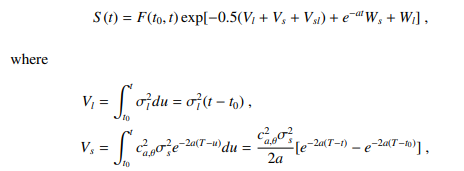


* The case of only one long-term factor

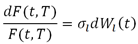

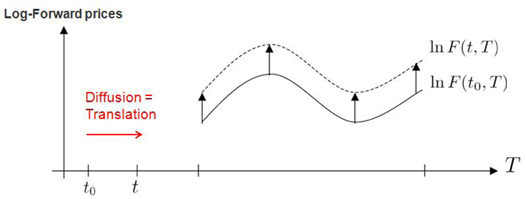




* The case of only one short-term factor

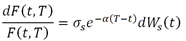

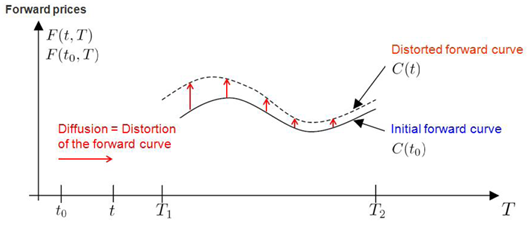


In [15]:
for j in range(1, nDays):
    
    # Spot Volatilities coefficients
    V_l_spot = vol_l** 2 * t
    V_s_spot = (c**2 * vol_s**2 / (2 * a)) * (1 - np.exp(-2 * a * t))

    # Diffusion coefficients
    W_s[j] = W_s[j-1] * np.exp(-a * dt) + np.sqrt((c**2 * vol_s**2 / (2 * a)) * (1 - np.exp(-2 * a * dt))) * rn_s[j]
    W_l[j] = W_l[j-1] + np.sqrt(vol_l**2 * dt) * rn_l[j]
    
    # Spot Price construction
    S[j] = da_curve[j] * np.exp(-0.5 * (V_l_spot[j] + V_s_spot[j]) + W_s[j] + W_l[j])
    
    for iMaturity in range(0, nMaturities):

        # Forward Volatility coefficients
        V_l = vol_l** 2 * t
        V_s = (c**2 * vol_s**2 / (2 * a)) * (np.exp(-2 * a * (T[iMaturity]-t)) - np.exp(-2 * a * T[iMaturity]))
        
        # Forward Price construction
        F[iMaturity, j, :] = np.where(T[iMaturity] - t[j] > 0, F[iMaturity, 0, :] * np.exp(-0.5 * (V_l[j] + V_s[j]) + np.exp(-a * (T[iMaturity] - t[j])) * W_s[j] + W_l[j]), F[iMaturity, j-1, :])


Once the simulation of 1000 paths is done, we can plot the first 30 paths so that we can understand the behavior of the model.

It is actually hard to tell the difference with a mere random walk, because the differences are small. 

Though, the average DA price is following the orange curve seen above. But since the variations of this curve are small, it is impossible to see them on this graph.



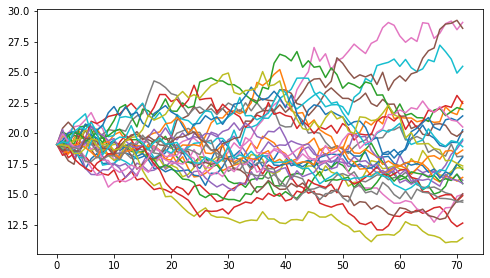

In [16]:
# Plot Spot
plt.figure(figsize=(8, 4.5))
plt.plot(S[:nDays+1,:30]);

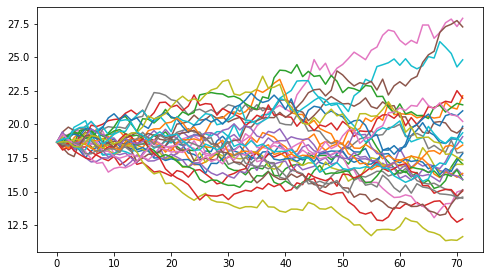

In [17]:
# Plot March Forward 
March = 3
plt.figure(figsize=(8, 4.5))
plt.plot(F[March,:nDays+1,:30]);

The interesting point here is to plot the spread prices (i.e. the difference between DA price and March price). It is clearly not a Brownian motion on this graph.

* the range of possible values is first spreading (as in a random walk) and then gathering back to a smaller range at the end of the path
* this is due to the fact that the da_curve is known in advance and the more time goes, the more the DA contract is close to march contract, the less the difference between these two contracts.



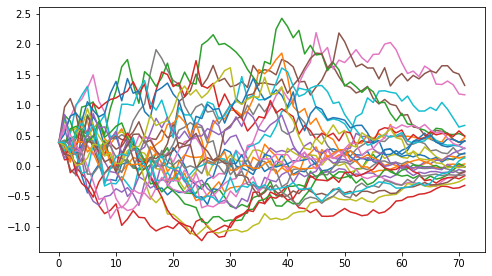

In [18]:
# Determination of Spread D = Spot - March
D = S[:nDays+1,:] - F[March,:nDays+1,:]

plt.figure(figsize=(8, 4.5))
plt.plot(D[:,0:30]);

## 3 - Swing option valuation

The method developed by Longstaff and Schwartz (2002) for American and
Bermudan options uses least square regression to decide whether to exercise
the option or keep it. This decision is made for each simulated spot price
path and at each time step as the algorithm moves backwards in time. In
order to make the decision we need to determine the value in continuing
with the option versus the cash flow received when exercising the option
at the current time point. We can express the continuation value as the
expectation of the future payoffs conditional on the information up to the
current time point.

When using the Swing Option LSM we need to add one more dimension,
i.e. the number of exercise rights left to use, to our already existing dimensions
for paths and time. We can let this extra dimension to be represented by
levels, one for each number of exercise rights left to use. The algorithm
work in a similar way to the one by Longstaff and Schwartz. The
difference is that when comparing whether to exercise or not, we need to
compare keeping the option as it is (staying at a certain level) or exercising
one right an continuing with one less exercise right (one level lower). We
also need to consider that when we decide to exercise a right for a certain
path, the subsequent cash flows for that path need to be substituted to
the subsequent cash flow of the option with one exercise right less than the
original one.

For further explanations, we suggest the reader can refer to [2], which is very
detailed with a step-by-step process.

In [19]:

# Swing Option Algo
def swingOptionAlgo(N, nDays, nSims, D):

    K = 0
    deg_poly = 3  # polynom degree

    # Initialization of matrices
    reg = np.zeros((nDays, deg_poly + 1 ,N))

    Y = np.zeros((nDays, nSims, N))
    C = np.zeros((nDays, nSims, N))
    V = np.zeros((nDays, nSims, N))

    # Least-Squares Monte Carlo Valuation (LSM algorithm)
    h = np.maximum(D - K, 0)

    # Initialization

    for J in range(0, N):
        for t in range(nDays-1, nDays-1-J-1, -1):
            V[t,:,J] = h[t-nDays]

    # We go step by step backward
    for t in range(nDays-1, 0, -1):
    
        # we compute all the regressions layer by layer for step t
        for J in range(0, N):
    
            Y[t,:,J] = V[:,:,J].sum(axis=0) 
            reg[t,:,J] = np.polyfit(D[t], Y[t,:,J], deg = deg_poly)
            C[t,:,J] = np.polyval(reg[t,:,J], D[t])
    
        # case for J > 0
        if nDays-t > 1:
        
            # We go from layer with maximum exercise rights to layer 2
            for J in range(min(nDays-t,N)-1,0,-1):
        
                # Option value = continuation C or exercise h(t)
                V[t-1,:,J] = np.where(h[t] + C[t,:,J-1] > C[t,:,J], h[t], 0)
                for k in range(t, nDays, 1):
                    V[k,:,J] = np.where(h[t] + C[t,:,J-1] > C[t,:,J], V[k,:,J-1], V[k,:,J])
    
        # separate case for J=0
        J=0
        # Option value = continuation C or exercise h(t) 
        V[t-1,:,J] = np.where(h[t] > C[t,:,J], h[t], 0)
        for k in range(t, nDays, 1):
            V[k,:,J] = np.where(h[t] > C[t,:,J], 0, V[k,:,0])

    # return the Value of the option 
    return V;


Winter season starts on November 1st. In this example, we are November 15th. We assume we start the season with 20 exercises rights and we have 15 exercises left with the storage asset.

Let's perform the swing option alorithm to get the value of the option with 15 exercises rights left. The more exercise rights left, the greater the swing option value.

The Plot of the cumulative swing option value depending on the number of exercise rights shows that the marginal exercise right value is always less than the previous one.

In [20]:
N = 15   # exercise rights left

In [21]:
# Value of Swing Option
V = swingOptionAlgo(N, nDays, nSims, D)
print('price of the option : ' ,round(V[:,:,N-1].sum(axis=0).mean(),2), 'EUR/MWh')

price of the option :  9.35 EUR/MWh


In order to determine wheather we should exercise the option or not, the actual spread is compared with the marginal exercise right value.

The marginal exercise right value is called the threshold : if the current DA - March spread is higher than this threshold, one should exercise the option.

In [22]:
# Value of the option for J exercise rights
Value = np.zeros((N))
for J in range(0, N):
    Value[J] = V[:,:,J].sum(axis=0).mean()

# Individual exercise value
Threshold = np.diff(np.insert(Value, 0, 0, axis=0))
print('marginal exercise right value :', round(Threshold[-1],3))  # marginal exercise right value

marginal exercise right value : 0.584


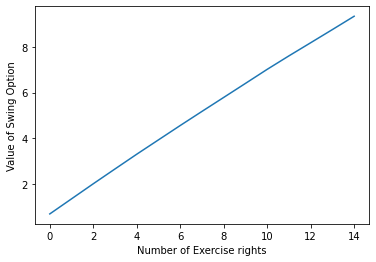

In [23]:
plt.xlabel('Number of Exercise rights')
plt.ylabel('Value of Swing Option')
plt.plot(Value); 

In [24]:
print('spread value at t = 0 : ', round(D[0].mean(),3))  # spread value at t = 0

spread value at t = 0 :  0.388


We can observe the spread value is lesser than the marginal exercise right value. The conclusion here is that we do not exercise our option right to withdraw.

## 4 - Application to the 2017 winter season


Now that we have seen the process for one specific trading day, we can go ahead and replicate this to the 82 trading days of winter season 2017. 

For the rest of the paper, maximum storage volume is initialized to 1000 MWh (i.e. 1 GWh). This will help us understand how much PnL is expected out of 1 GWh storage subscription.

Number of exercise rights is inialized to a maximum of 40. The interesting feature in our code (the previous Swing option algo and the following function mainAlgo) is that we are able to store big matrices of results with up to Nmax exercise rights. And if you only need result for N < Nmax, the result is contained in the bigger matrix. The idea is to calculate all the possible thresholds from 1 to Nmax at each step.

The mainAlgo takes a long time (because it repeats all the steps seen above for every trading day during winter season), but once it is finished, you can more easily play with the results.



In [25]:
Volume = 1000
Nmax = 40          # Maximum number of exercise rights we are going to need for our sutudies.

In [28]:
def mainAlgo(N, n_year):
    
    print(n_year)    
    dt_end = str(n_year+1) + '-02-29'
    
    # Loading DA data from csv
    df_DA_prices = pd.read_csv('Project - data/' + str(n_year) + '_DA.csv',  index_col = 0).loc[:dt_end]
    df_DA_prices.index.name = 'dt_trading'
    
    # Loading curve data from csv
    df_curve_prices = pd.read_csv('Project - data/' + str(n_year) + '_curve.csv',  index_col = 0).loc[:dt_end]  
    
    # Periods parameters
    dt = 1/252  # daily step
    theta = 1/12  # monthly step 
        
    df_result = pd.DataFrame()
    
    for i in range(0, len(df_curve_prices)):
        
        dt_trade = df_curve_prices.index[i]
        print('\r{} / ' .format(i+1, len(df_curve_prices)) + str(len(df_curve_prices)), end=' ')
    
        da_curve = df_DA_prices[dt_trade].dropna()
        curve = df_curve_prices.loc[dt_trade]
        
        # dimensions
        nDays = len(df_curve_prices.loc[dt_trade:dt_end])
        nMaturities = len(curve)
        nSims = 1000
    
        # Volatility parameters
        vol_s = 0.5
        vol_l = 0.1
        a = 1.5
        
        c = (1/(a*theta))*(1-np.exp(-a*theta))

        # Initialization
        T = np.zeros(nMaturities)
        F = np.zeros((nMaturities, nDays, nSims))
        S = np.zeros((nDays, nSims))

        # Construction of random variables
        np.random.seed(100)
        rn1 = np.random.standard_normal((nDays, nSims)) 
        rn2 = np.random.standard_normal((nDays, nSims))

        W_s = np.zeros_like(rn1)
        W_l = np.zeros_like(rn1)
    
        # Initialization of Curve and Spot
        F[:,0,:] = np.repeat(curve.to_numpy().ravel()[:,np.newaxis], nSims, 1)
        S[:,0] = da_curve.loc[dt_trade:dt_end].values.tolist()
        S[0] = S[0,0]

        t = np.arange(0, nDays) * dt
        T = np.arange(1, nMaturities + 1) * theta

        for j in range(1, nDays):
    
            # Spot Volatilities coefficients
            V_l_spot = vol_l** 2 * t
            V_s_spot = (c**2 * vol_s**2 / (2 * a)) * (1 - np.exp(-2 * a * t))

            # Diffusion coefficients
            W_s[j] = W_s[j-1] * np.exp(-a * dt) + np.sqrt((c**2 * vol_s**2 / (2 * a)) * (1 - np.exp(-2 * a * dt))) * rn1[j]
            W_l[j] = W_l[j-1] + np.sqrt(vol_l**2 * dt) * rn2[j]
    
            # Spot Price construction
            S[j] = da_curve[j] * np.exp(-0.5 * (V_l_spot[j] + V_s_spot[j]) + W_s[j] + W_l[j])
    
            for iMaturity in range(0, nMaturities):

                # Forward Volatility coefficients
                V_l = vol_l** 2 * t
                V_s = (c**2 * vol_s**2 / (2 * a)) * (np.exp(-2 * a * (T[iMaturity]-t)) - np.exp(-2 * a * T[iMaturity]))
        
                # Forward Price construction
                F[iMaturity, j, :] = np.where(T[iMaturity] - t[j] > 0, F[iMaturity, 0, :] * np.exp(-0.5 * (V_l[j] + V_s[j]) + np.exp(-a * (T[iMaturity] - t[j])) * W_s[j] + W_l[j]), F[iMaturity, j-1, :])

        # Determination of Spread D = Spot - March
        March = 3
    
        D = S[:nDays+1,:] - F[March,:nDays+1,:]
    
        N = np.minimum(N, nDays)
        
        if N > 0:
        
            V = swingOptionAlgo(N, nDays, nSims, D)
            # Value of the option for J exercise rights
            Value = np.zeros((N))
            
            for J in range(0, N):
                Value[J] = V[:,:,J].sum(axis=0).mean()

            # Individual exercise value
            Threshold = np.diff(np.insert(Value, 0, 0, axis=0))


        step = [[dt_trade, nDays, D[0].mean(), Threshold]]

        df_result = df_result.append(pd.DataFrame(step, columns = ['dt_trading', 'nDays' , 'spread value', 'threshold']), ignore_index = True)

    print("\n")
    
    return df_result;


In [29]:
df_result_2017 = mainAlgo(Nmax, n_year)

2017
82 / 82 



The top 3 rows of the 2017 result matrix are displayed below.

We can observe the threshold column contains a whole array. This is because swing option algo is testing every number of possible exercise rights left. So the output is an array of Nmax dimension.

In [30]:
df_result_2017.head(3)

,dt_trading,nDays,spread value,threshold
0,2017-11-01,82,0.014,"[0.6159018659397703, 0.6042607129352063, 0.596..."
1,2017-11-02,81,-0.179,"[0.6262925948524999, 0.6180728660078406, 0.619..."
2,2017-11-03,80,0.172,"[0.6298605589921547, 0.617747677120668, 0.6079..."


For example, for the first trading day, the marginal threshold value is 0.36.

In [31]:
df_result_2017.loc[0, 'threshold'][-1].round(2)

0.36

Now we need to perform a loop in which we are going to mark where 'spread value' is higher than the corresponding threshold (depending of the number of rights left N). And if it is the case, N will be decreased by one unit. 

This function is called 'exercise_1' because it is assumed we can only trigger one shot per day. Each time the 'spread value' is higher than the 'threshold', the withdraw volume will be exactly equal to 'Exercise_Volume'.

This allows us to print the exercise volume in front of each occurence of an exercise right used.

These code parts are written as functions because they will be used multiple times in the following sections.


In [32]:
def exercise_1(df, N):
    
    Exercise_Volume = round(Volume / N, 2)

    df.loc[0, 'right'] = N

    for i in range(0, len(df)):
        m = min(int(df.loc[i, 'right']), len(df.loc[i, 'threshold']))   
        df.loc[i, 'thresh'] = df.loc[i, 'threshold'][-m]
        df.loc[i+1, 'right'] = np.where(((df.loc[i, 'right'] >= df.loc[i, 'nDays']) * (df.loc[i, 'spread value'] > 0)) + (df.loc[i, 'spread value'] >= df.loc[i, 'thresh']), max(df.loc[i, 'right']-1, 0), df.loc[i, 'right'])
    
    df['exercise'] = df['right'].diff(periods=-1)
    df.drop(df.tail(1).index,inplace=True)
    df['exercise_vol'] = df['exercise'] * Exercise_Volume
    df = df.drop(['threshold'], axis=1)
    
    return df;

### 4.1 - Slow storage asset


First, we will assume we have a gas storage asset capable of withdrawing its whole capacity in 40 days. These assets are commonly called **slow storage assets**. They are not flexible assets for storage optimizations. Yet, it is interesting to find out if our algorithm is capable of optimizing their withdrawal trajectories.

In [33]:
N = 40
df_result_1 = exercise_1(df_result_2017, N)

The PnL function aims to define all the cumulative PnL results from our different startegies:

* The 'Swing' strategy is simply the strategy that comes out of our previous algorithm. So the exercise volume is multiplied by the spread value 

* The 'RO' strategy refers to Real Option strategy. This is the most basic strategy: each time the spread value is positive, withdraw 1/d of the volume left and take profit of this spread (d being the number of trading days left)

* The 'RO_1' strategy is identical to the Real Option strategy with a threshold of 1 EUR/MWh: each time the spread value is more than 1, withdraw 1/d of the volume left and take profit of this spread.


In [34]:
def PnL(df, N):
    
    # Initialization
    Exercise_Volume = round(Volume / N, 2)
    df.loc[0, 'vol_RO'] = np.where(df.loc[0, 'spread value'] > 0, round(Volume / df.loc[0, 'nDays'],0), 0)
    df.loc[0, 'vol_RO_1'] = np.where(df.loc[0, 'spread value'] > 1, round(Volume / df.loc[0, 'nDays'],0), 0)
    
    # For loop used beacause value on i depends on values on i-1
    for i in range(1, len(df)):
        df.loc[i, 'vol_RO'] = np.where(df.loc[i, 'spread value'] > 0, round(np.minimum(Exercise_Volume, (Volume - df.loc[0:i-1, 'vol_RO'].sum()) / df.loc[i, 'nDays']),3), 0)
        df.loc[i, 'vol_RO_1'] = np.where(df.loc[i, 'spread value'] > 1, round(np.minimum(Exercise_Volume, (Volume - df.loc[0:i-1, 'vol_RO_1'].sum()) / df.loc[i, 'nDays']),3), 0)
        
    # Cumulative PnL calculation
    df['PnL_swing'] = (df['exercise_vol'] * df['spread value']).cumsum().round(1)
    df['PnL_RO'] = (df['vol_RO'] * df['spread value']).cumsum().round(1)
    df['PnL_RO_1'] = (df['vol_RO_1'] * df['spread value']).cumsum().round(1)
    
    return df;

After performing the PnL function to our first result dataframe, we decided to show some rows in which the reader can see examples of option rights that are exercised. So the PnL rises accordingly.

In [35]:
df_result_1 = PnL(df_result_1, N)
df_result_1.iloc[27:35]                # Interesting window to show

,dt_trading,nDays,spread value,right,thresh,exercise,exercise_vol,vol_RO,vol_RO_1,PnL_swing,PnL_RO,PnL_RO_1
27,2017-12-08,55.0,0.653,38.0,0.863162,0.0,0.0,12.35,0.000,40.4,149.5,0.0
28,2017-12-11,54.0,1.038,38.0,0.922813,1.0,25.0,12.35,18.519,66.4,162.3,19.2
29,2017-12-12,53.0,1.057,37.0,0.996730,1.0,25.0,12.35,18.519,92.8,175.4,38.8
30,2017-12-13,52.0,1.248,36.0,0.987094,1.0,25.0,12.35,18.518,124.0,190.8,61.9
31,2017-12-14,51.0,0.955,35.0,0.892473,1.0,25.0,12.35,0.000,147.9,202.6,61.9
32,2017-12-15,50.0,1.266,34.0,0.982415,1.0,25.0,12.35,18.889,179.5,218.2,85.8
33,2017-12-18,49.0,1.264,33.0,0.883741,1.0,25.0,12.35,18.889,211.1,233.9,109.7
34,2017-12-19,48.0,0.747,32.0,0.820749,0.0,0.0,12.35,0.000,211.1,243.1,109.7


The final row shows the cumulated realized PnL of the 3 strategies.

In [36]:
df_result_1.tail(1)

,dt_trading,nDays,spread value,right,thresh,exercise,exercise_vol,vol_RO,vol_RO_1,PnL_swing,PnL_RO,PnL_RO_1
81,2018-02-27,1.0,15.671,6.0,15.671,1.0,25.0,15.63,25.0,1145.0,868.2,929.1


In order to visually show the results of each strategy, we create the following function: graph_PnL():

In [37]:
def graph_PnL(df):

    import matplotlib.pyplot as plt
    from matplotlib import rc
    rc('mathtext', default='regular')

    fig = plt.figure(figsize=(10, 6))
    fig, ax_left = plt.subplots(figsize=(10, 6))
    ax_right = ax_left.twinx()

    ax_left.plot(df['spread value'], color='grey', label='spread value')
    ax_right.plot(df['PnL_swing'], color='purple', label='PnL_Swing')
    ax_right.plot(df['PnL_RO'], color='blue', label='PnL_RO')
    ax_right.plot(df['PnL_RO_1'], color='green', label='PnL_RO_1')
    
    ax_left.set_title(str(2017))
       
    ax_right.set_ylabel(r"Cumulative PnL (EUR)")
    ax_left.set_ylabel(r"DA / March Spreads (EUR/MWh)")
    
    ax_right.legend(loc="upper left")
    ax_left.legend(loc="upper center")

    ax_left.grid()
    plt.show();

<Figure size 720x432 with 0 Axes>

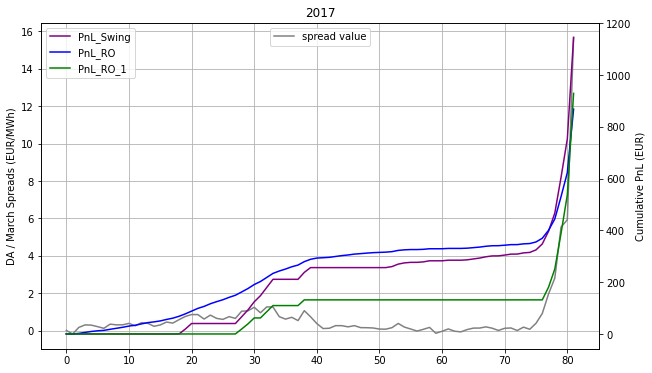

In [38]:
graph_PnL(df_result_1)

This graph is very interesting to understand the whole process.

The realized DA - March spread value is displayed in grey. 2017 was a very remarkable year: at the end of february, DA contract went to very high levels. 

The Swing, OR and OR_1 PnL are displayed in purple, blue and green respectively.

Here we can observe that our algos take advantage of the last spread values beacause they still have volume to withdraw at the end of the season, which is fortunate.


In [39]:
max_perf_list = df_result_1.nlargest(N, 'spread value')['spread value']
max_perf_list = max_perf_list[max_perf_list>0]
max_perf = round(max_perf_list.mean() * Volume * len(max_perf_list) / N, 1)

print('Fictive maximum PnL on 2017 :', max_perf)

Fictive maximum PnL on 2017 : 1392.9


In [40]:
swing_vs_max = df_result_1['PnL_swing'].iloc[-1] / max_perf
print('Swing algo performance vs. fictive maximum PnL on 2017 :', '{0:.0%}'.format(swing_vs_max))

Swing algo performance vs. fictive maximum PnL on 2017 : 82%


In [41]:
RO_vs_max = df_result_1['PnL_RO'].iloc[-1] / max_perf
print('Real Option strategy vs. fictive maximum PnL on 2017 :', '{0:.0%}'.format(RO_vs_max))

Real Option strategy vs. fictive maximum PnL on 2017 : 62%


In [42]:
RO1_vs_max = df_result_1['PnL_RO_1'].iloc[-1] / max_perf
print('Real Option strategy > 1 vs. fictive maximum PnL on 2017 :', '{0:.0%}'.format(RO1_vs_max))

Real Option strategy > 1 vs. fictive maximum PnL on 2017 : 67%


In [43]:
storage_usage = df_result_1['exercise_vol'].sum() / Volume
print('storage usage :', '{0:.0%}'.format(storage_usage))

storage usage : 88%


Results are quite good for our swing Algo, that gets to capture 82% of total maximum possible PnL (1392 EUR). That can be explained by the fact that we start the winter season with 40 possible exercise right out of 82 trading days, which is close to one exercise right every other day.

### 4.2 - Fast storage asset


Now, we will assume we have a gas storage asset capable of withdrawing its whole capacity in 20 days. This is usually called a **fast storage asset**. 

This kind of storage is the heart of our study because the are the most flexible assets for storage optimizations. This study aims at taking as much value as possible out of the theoretical maximum value.


In [44]:
N_2 = 20
df_result_2 = exercise_1(df_result_2017, N_2)

In [45]:
df_result_2 = PnL(df_result_2, N_2)
df_result_2.tail(1)

,dt_trading,nDays,spread value,right,thresh,exercise,exercise_vol,vol_RO,vol_RO_1,PnL_swing,PnL_RO,PnL_RO_1
81,2018-02-27,1.0,15.671,0.0,15.671,0.0,0.0,15.63,50.0,802.3,868.2,1726.5


<Figure size 720x432 with 0 Axes>

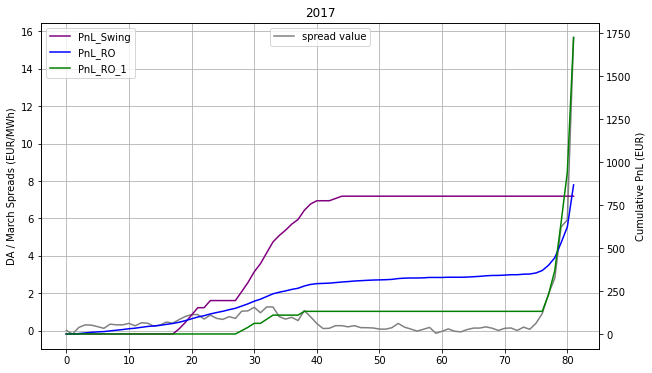

In [46]:
graph_PnL(df_result_2)

It is interesting to see that the last spread values are very high. Unfortunately there is no exercise right remaining for the Swing option at this point. That explaines the quite poor results of this strategy.

On the other hand, the Real Option with threshold 1 is very efficient due to a large volume left at the end of the season.


In [47]:
max_perf_list = df_result_2.nlargest(N_2, 'spread value')['spread value']
max_perf_list = max_perf_list[max_perf_list>0]
max_perf = round(max_perf_list.mean() * Volume * len(max_perf_list) / N_2, 1)

print('Fictive maximum PnL on 2017 :', max_perf)

Fictive maximum PnL on 2017 : 2312.2


In [48]:
swing_vs_max = df_result_2['PnL_swing'].iloc[-1] / max_perf
print('Swing algo performance vs. fictive maximum PnL on 2017 :', '{0:.0%}'.format(swing_vs_max))

Swing algo performance vs. fictive maximum PnL on 2017 : 35%


In [49]:
RO_vs_max = df_result_2['PnL_RO'].iloc[-1] / max_perf
print('Real Option strategy vs. fictive maximum PnL on 2017 :', '{0:.0%}'.format(RO_vs_max))

Real Option strategy vs. fictive maximum PnL on 2017 : 38%


In [50]:
RO1_vs_max = df_result_2['PnL_RO_1'].iloc[-1] / max_perf
print('Real Option strategy > 1 vs. fictive maximum PnL on 2017 :', '{0:.0%}'.format(RO1_vs_max))

Real Option strategy > 1 vs. fictive maximum PnL on 2017 : 75%


In [51]:
storage_usage = df_result_2['exercise_vol'].sum() / Volume
print('storage usage :', '{0:.0%}'.format(storage_usage))

storage usage : 100%


There are several points to raise here:

* Fictive maximum PnL (2312 EUR) with the fast storage asset is close to two times the one for slwo storage asset. That is because we only picked the 20 best values instead of the 40 best values. So the performance is relatively harder to rise compared to slow storage asset.

* Nevertheless, the performance of the swing algo is poorer than both the real option strategies.

* One can note that the best strategy in this case is the real option with a threshold of 1 EUR/MWh.

### 4.3 - Fast storage asset with 2 possible exercise rights per day


In this section, we keep our gas storage asset capable of withdrawing its whole capacity in 20 days. However, it is possible to devide the storage asset in 40 withdrawal volumes. So, for one specific trading day, the algorithm has to decide between three possibilities:

* if spread value < threshold : do nothing
* if spread value > threshold : withdraw 1/40 of total volume
* if spread value > threshold + 10% : withdraw 1/20 of total volume

The idea here is to withdraw lower volumes when the spread value is not largely higher than threshold. So that we keep some volume for larger spread values. 

The results of this algo will be still compared with Real Options strategies with **fast storage**.

This algorithm is defined by function exercise_2() below.

In [52]:
# avec 2 shots possibles

def exercise_2(df, N):
    
    Exercise_Volume = round(Volume / N, 2)

    df.loc[0, 'right'] = N

    for i in range(0, len(df)):
        m = min(int(df.loc[i, 'right']), len(df.loc[i, 'threshold']))
    
        df.loc[i, 'thresh_1'] = df.loc[i, 'threshold'][-m]
        df.loc[i, 'thresh_2'] = df.loc[i, 'thresh_1'] * 1.1
    
        df.loc[i+1, 'right'] = np.where(((df.loc[i, 'right'] >= df.loc[i, 'nDays']*2) * (df.loc[i, 'spread value'] > 0)) + (df.loc[i, 'spread value'] >= df.loc[i, 'thresh_1']), max(df.loc[i, 'right']-1, 0), df.loc[i, 'right'])
        df.loc[i+1, 'right'] = np.where(((df.loc[i, 'right'] >= df.loc[i, 'nDays']*2) * (df.loc[i, 'spread value'] > 0)) + (df.loc[i, 'spread value'] >= df.loc[i, 'thresh_2']), max(df.loc[i+1, 'right']-1, 0), df.loc[i+1, 'right'])
    
    df['exercise'] = df['right'].diff(periods=-1)
    df.drop(df.tail(1).index,inplace=True)
    df['exercise_vol'] = df['exercise'] * Exercise_Volume
    df = df.drop(['threshold'], axis=1)
    
    return df;

In [53]:
N_3 = 40
df_result_3 = exercise_2(df_result_2017, N_3)

After performing the PnL function to our first result dataframe, we decided to show some rows in which the reader can see examples of option rights that are exercised. We can observe occurences with 2 exercises and some with 1 exercise only.

In [54]:
df_result_3 = PnL(df_result_3, N_3/2)  # N_3 / 2 because we want to compare this performance with the case with 20 exercise rights.
df_result_3.iloc[35:40]

,dt_trading,nDays,spread value,right,thresh,exercise,exercise_vol,thresh_1,thresh_2,vol_RO,vol_RO_1,PnL_swing,PnL_RO,PnL_RO_1
35,2017-12-20,47.0,0.616,26.0,0.589392,0.0,0.0,0.761146,0.837261,12.35,0.000,376.8,250.7,109.7
36,2017-12-21,46.0,0.712,26.0,0.492046,1.0,25.0,0.691912,0.761103,12.35,0.000,394.6,259.5,109.7
37,2017-12-22,45.0,0.537,25.0,0.458728,0.0,0.0,0.644743,0.709218,12.35,0.000,394.6,266.1,109.7
38,2017-12-27,44.0,1.067,25.0,0.300291,2.0,50.0,0.595499,0.655049,12.35,20.606,448.0,279.3,131.7
39,2017-12-28,43.0,0.740,23.0,0.358470,2.0,50.0,0.621028,0.683131,12.35,0.000,485.0,288.4,131.7


In [55]:
df_result_3.tail(1)

,dt_trading,nDays,spread value,right,thresh,exercise,exercise_vol,thresh_1,thresh_2,vol_RO,vol_RO_1,PnL_swing,PnL_RO,PnL_RO_1
81,2018-02-27,1.0,15.671,3.0,15.671,2.0,50.0,15.671,17.2381,15.63,50.0,2158.5,868.2,1726.5


<Figure size 720x432 with 0 Axes>

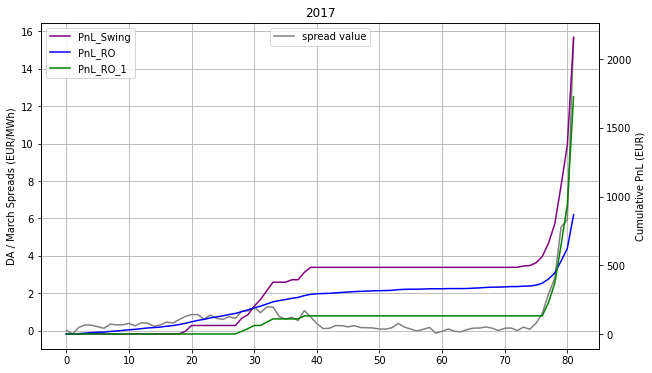

In [56]:
graph_PnL(df_result_3)

Now the performance is really optimal as one can see on the graph. It is interesting to see that this new strategy takes advantage of the last wave of large spread values. Again, the idea here is that when profits are not too big, only half of the volume is withdrawn (1/40 instead of 1/20) which makes the startegy save some volume for other time when the profits will rise.

In [57]:
max_perf_list = df_result_3.nlargest(int(N_3/2), 'spread value')['spread value']
max_perf_list = max_perf_list[max_perf_list>0]
max_perf = round(max_perf_list.mean() * Volume * len(max_perf_list) / int(N_3/2), 1)

print('Fictive maximum PnL on 2017 :', max_perf)

Fictive maximum PnL on 2017 : 2312.2


In [58]:
swing_vs_max = df_result_3['PnL_swing'].iloc[-1] / max_perf
print('Swing algo performance vs. fictive maximum PnL on 2017 :', '{0:.0%}'.format(swing_vs_max))

Swing algo performance vs. fictive maximum PnL on 2017 : 93%


In [59]:
RO_vs_max = df_result_3['PnL_RO'].iloc[-1] / max_perf
print('Real Option strategy vs. fictive maximum PnL on 2017 :', '{0:.0%}'.format(RO_vs_max))

Real Option strategy vs. fictive maximum PnL on 2017 : 38%


In [60]:
RO1_vs_max = df_result_3['PnL_RO_1'].iloc[-1] / max_perf
print('Real Option strategy >1 vs. fictive maximum PnL on 2017 :', '{0:.0%}'.format(RO1_vs_max))

Real Option strategy >1 vs. fictive maximum PnL on 2017 : 75%


In [61]:
storage_usage = df_result_3['exercise_vol'].sum() / Volume
print('storage usage :', '{0:.0%}'.format(storage_usage))

storage usage : 98%


The fictive maximum PnL is of course the same for this fast storage asset (2312 EUR). Similarly, the two Real Option strategies get the exact same results as the previous case because we still deal with the same fast storage asset.

The result of our Swing algo with 10% threshold is quite excellent. It can capture 93% of total possible PnL.



## 5 - Application to 10 years historical data


Now that we have seen the process for one specific winter season, we can go ahead and replicate this to the whole data set, which contains 10 winter seasons over 10 years.

For the rest of the paper, maximum storage volume is initialized to 1000 MWh (i.e. 1 GWh). This will help us understand how much PnL is expected out of 1 GWh storage subscription.

Number of exercise rights is still inialized to a maximum of 40.

Again, the mainAlgo takes a long time, but once it is finished, you can more easily play with the results.

Let's process our whole historic data through this algo... depending on the user's machine, this can take between 20 to 40 minutes.

In [62]:
%%time

Nmax = 40
list_df_result = list()

for i in range(10):
    list_df_result.append(mainAlgo(Nmax, 2010+i))
    

2010
82 / 82  

2011
83 / 83   

2012
82 / 82  

2013
82 / 82  

2014
81 / 81   

2015
82 / 82   

2016
82 / 82   

2017
82 / 82   

2018
82 / 82    

2019
82 / 82   

Wall time: 35min 48s


### 5.1 - Slow storage asset

Like in 4. Section, we first assume we have a gas storage asset capable of withdrawing its whole capacity in 40 days, i.e. a slow storage asset.


We create two lists of DataFrames in order to store the results of functions exercise and PnL.

In [63]:
Volume = 1000
N1 = 40

list_df_exercise = list()
list_df_performance_1 = list()

for i in range(10):    
    list_df_exercise.append(exercise_1(list_df_result[i], N1))
    list_df_performance_1.append(PnL(list_df_exercise[i], N1))


In order to visually show the results of each strategy for the 10 historical winter seasons, we create the following function: overall_graphs():

In [64]:
def overall_graphs(list_df):

    fig, ax_left = plt.subplots(5,2, figsize=(15, 25), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .25, wspace=.35)

    ax_right = np.empty_like(ax_left)

    ax_left = ax_left.ravel()
    ax_right = ax_right.ravel()

    for i in range(10):
    
        ax_right[i] = ax_left[i].twinx()

        ax_left[i].plot(list_df[i]['spread value'], color='grey', label='spread value')
        ax_right[i].plot(list_df[i]['PnL_swing'], color='purple', label='PnL_Swing')
        ax_right[i].plot(list_df[i]['PnL_RO'], color='blue', label='PnL_RO')
        ax_right[i].plot(list_df[i]['PnL_RO_1'], color='green', label='PnL_RO_1')
    
        ax_left[i].set_title(str(2010+i))
      
        ax_right[i].set_ylabel(r"Cumulative PnL (EUR)")
        ax_left[i].set_ylabel(r"DA / March Spreads (EUR/MWh)")
    
        ax_right[i].legend(loc="upper left")
        ax_left[i].legend(loc="upper center")
    
        ax_left[i].grid()


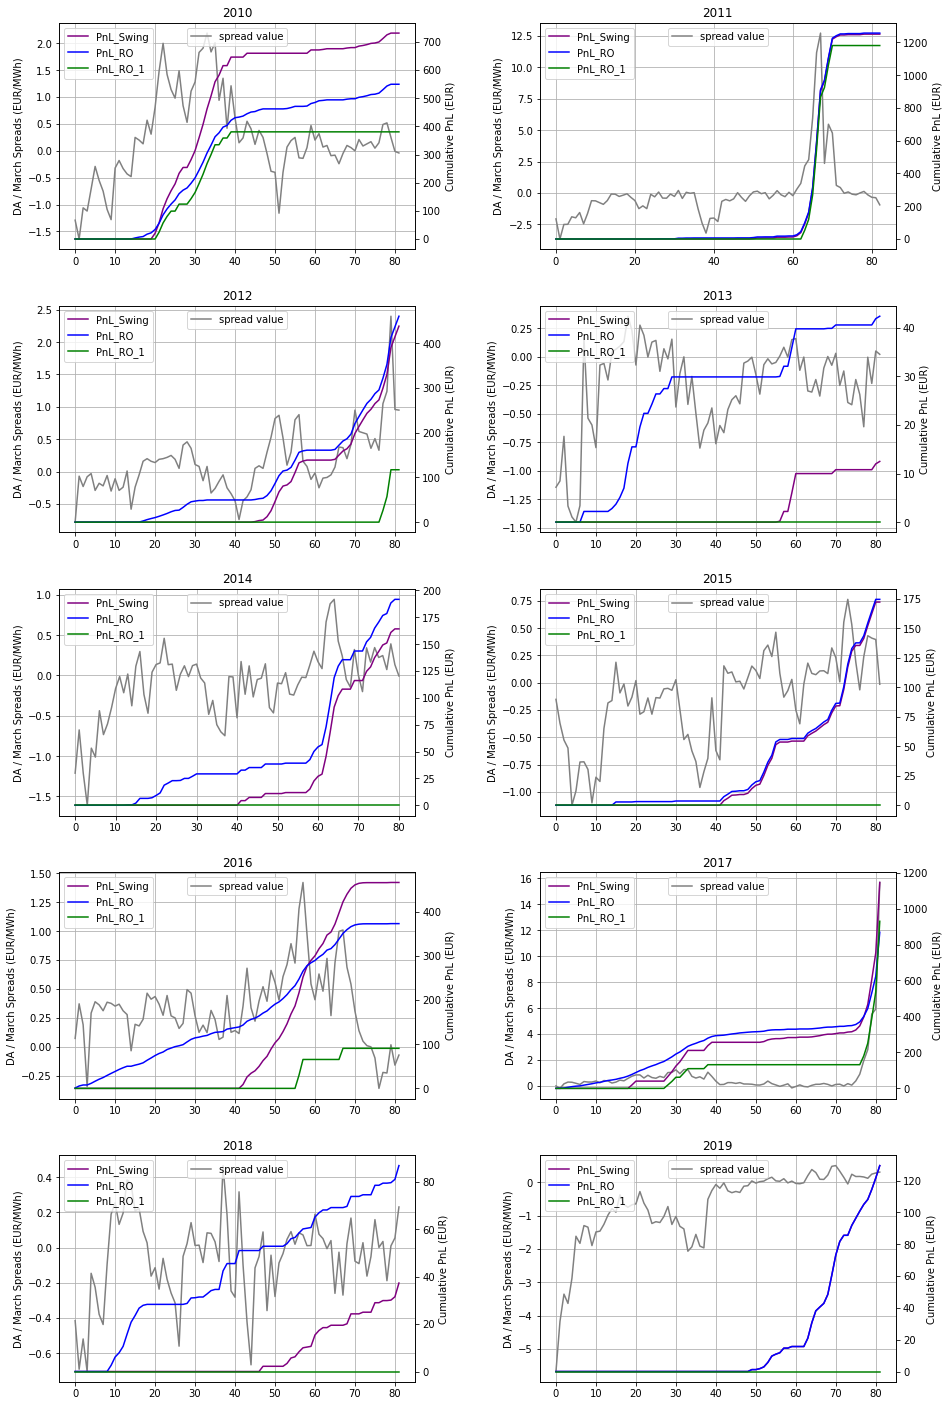

In [65]:
overall_graphs(list_df_performance_1)

In order to show an elegant summary of the 10-year results, we create the function overall_perf(). It performs the calculations of the different PnL and their perfomance vs. max_perf (the maximum fictive PnL of the year).

In [66]:
def overall_perf(list_df, N_i):

    sto_year, list_PnL_swing, list_PnL_RO, list_PnL_RO_1, list_storage_usage, max_perf = [],[],[],[],[],[]

    for i in range(10):
        sto_year.append(2010+i)
        list_PnL_swing.append(list_df[i]['PnL_swing'].iloc[-1])
        list_PnL_RO.append(list_df[i]['PnL_RO'].iloc[-1])
        list_PnL_RO_1.append(list_df[i]['PnL_RO_1'].iloc[-1])
        list_storage_usage.append(list_df[i]['exercise_vol'].sum() / Volume)
        
        max_perf_list = list_df[i].nlargest(N_i, 'spread value')['spread value']
        max_perf_list = max_perf_list[max_perf_list>0]
        max_perf.append(round(max_perf_list.mean() * Volume * len(max_perf_list) / N_i, 1))

    df = pd.DataFrame({'sto_year':sto_year, 'PnL_swing':list_PnL_swing, 'PnL_RO':list_PnL_RO, 'PnL_RO_1':list_PnL_RO_1, 'storage_usage':list_storage_usage, 'max_perf':max_perf})

    df['perf_vs_max'] = df['PnL_swing'] / df['max_perf']
    df['RO_vs_max'] = df['PnL_RO'] / df['max_perf']
    df['RO_1_vs_max'] = df['PnL_RO_1'] / df['max_perf']

    df['storage_usage'] = df['storage_usage'].astype(float).map("{:.0%}".format)
    df['perf_vs_max'] = df['perf_vs_max'].astype(float).map("{:.0%}".format)
    df['RO_vs_max'] = df['RO_vs_max'].astype(float).map("{:.0%}".format)
    df['RO_1_vs_max'] = df['RO_1_vs_max'].astype(float).map("{:.0%}".format)
    
    return df;

In [67]:
df_perf_1 = overall_perf(list_df_performance_1, N1)
df_perf_1

,sto_year,PnL_swing,PnL_RO,PnL_RO_1,storage_usage,max_perf,perf_vs_max,RO_vs_max,RO_1_vs_max
0,2010,731.0,549.4,380.4,82%,840.5,87%,65%,45%
1,2011,1250.5,1256.9,1181.0,50%,1259.0,99%,100%,94%
2,2012,438.5,460.7,117.2,78%,508.5,86%,91%,23%
3,2013,12.5,42.4,0.0,20%,63.6,20%,67%,0%
4,2014,164.2,191.7,0.0,55%,211.7,78%,91%,0%
5,2015,172.3,174.6,0.0,80%,178.2,97%,98%,0%
6,2016,465.8,372.7,90.6,82%,585.4,80%,64%,15%
7,2017,1145.0,868.2,929.1,88%,1392.9,82%,62%,67%
8,2018,37.3,86.8,0.0,52%,122.9,30%,71%,0%
9,2019,129.4,129.4,0.0,68%,129.4,100%,100%,0%


comments on individual year

In [68]:
print('Cumulative fictive maximum PnL over 10 years :', df_perf_1['max_perf'].sum().round(0))

Cumulative fictive maximum PnL over 10 years : 5292.0


In [69]:
overall_performance_max = df_perf_1['PnL_swing'].sum() / df_perf_1['max_perf'].sum()
print('overall Swing algo performance vs. fictive maximum PnL over 10 years :', '{0:.0%}'.format(overall_performance_max))

overall Swing algo performance vs. fictive maximum PnL over 10 years : 86%


In [70]:
overall_RO_vs_max = df_perf_1['PnL_RO'].sum() / df_perf_1['max_perf'].sum()
print('overall Real Option strategy vs. fictive maximum PnL over 10 years :', '{0:.0%}'.format(overall_RO_vs_max))

overall Real Option strategy vs. fictive maximum PnL over 10 years : 78%


In [71]:
overall_RO_1_vs_max = df_perf_1['PnL_RO_1'].sum() / df_perf_1['max_perf'].sum()
print('overall Real Option 1 EUR strategy vs. fictive maximum PnL over 10 years :', '{0:.0%}'.format(overall_RO_1_vs_max))

overall Real Option 1 EUR strategy vs. fictive maximum PnL over 10 years : 51%


Overall results are very good. They are only disappointing when there is poor PnL to make anyway (2013, 2018).

Again, good results can be explained by the fact that we start the winter season with 40 possible exercise right out of 82 trading days, which is close to one exercise right every other day.

So it is very much more challenging to see the results for fast storage asset in the following section.

### 5.2 - Fast storage asset




In this section, we again switch to a fast storage asset which swing strategy is going to be tested out of 10 years of winter seasons. 
We will use the same functions created earlier, which makes our code very clear and easy to read:

* create lists of dataframes containing results of strategies
* print graphs
* show summary of strategies results in overall performance DataFrame


In [72]:
Volume = 1000
N2 = 20

list_df_exercise = list()
list_df_performance_2 = list()

for i in range(10):    
    list_df_exercise.append(exercise_1(list_df_result[i], N2))
    list_df_performance_2.append(PnL(list_df_exercise[i], N2))

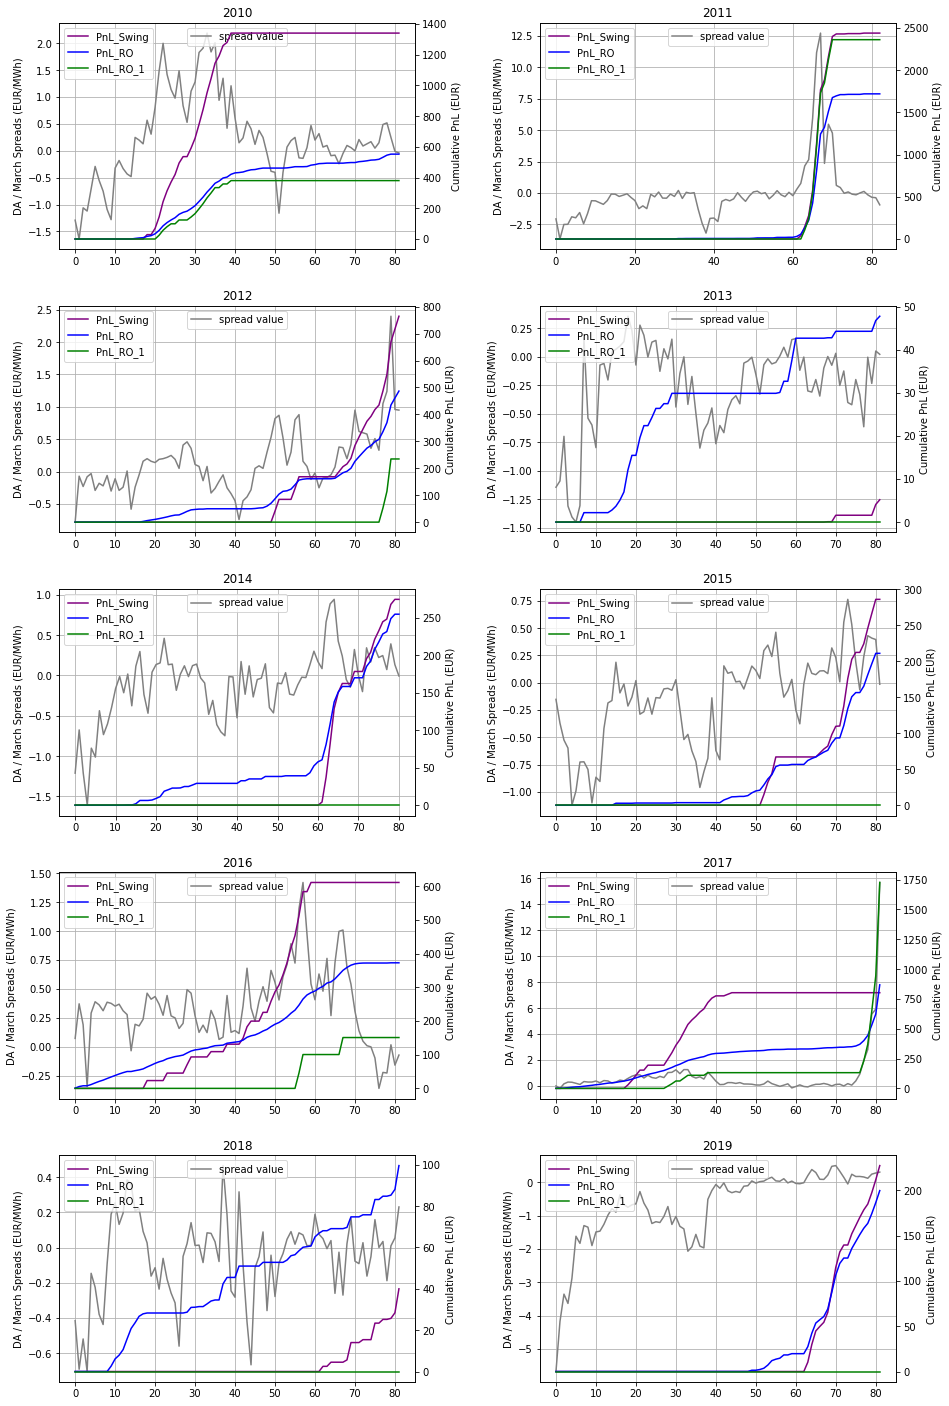

In [73]:
overall_graphs(list_df_performance_2)

In [74]:
df_perf_2 = overall_perf(list_df_performance_2, N2)
df_perf_2

,sto_year,PnL_swing,PnL_RO,PnL_RO_1,storage_usage,max_perf,perf_vs_max,RO_vs_max,RO_1_vs_max
0,2010,1341.0,552.7,380.4,100%,1350.5,99%,41%,28%
1,2011,2440.0,1720.0,2362.0,60%,2512.5,97%,68%,94%
2,2012,764.5,486.6,234.5,100%,797.5,96%,61%,29%
3,2013,5.2,47.8,0.0,20%,127.0,4%,38%,0%
4,2014,274.6,254.8,0.0,75%,352.3,78%,72%,0%
5,2015,286.0,211.0,0.0,90%,315.5,91%,67%,0%
6,2016,611.5,372.9,151.0,100%,767.0,80%,49%,20%
7,2017,802.3,868.2,1726.5,100%,2312.2,35%,38%,75%
8,2018,40.0,99.6,0.0,55%,208.1,19%,48%,0%
9,2019,227.4,199.8,0.0,90%,242.0,94%,83%,0%


In [75]:
print('Cumulative fictive maximum PnL over 10 years :', df_perf_2['max_perf'].sum().round(0))

Cumulative fictive maximum PnL over 10 years : 8985.0


In [76]:
overall_performance_max = df_perf_2['PnL_swing'].sum() / df_perf_2['max_perf'].sum()
print('overall Swing algo performance vs. fictive maximum PnL over 10 years :', '{0:.0%}'.format(overall_performance_max))

overall Swing algo performance vs. fictive maximum PnL over 10 years : 76%


In [77]:
overall_RO_vs_max = df_perf_2['PnL_RO'].sum() / df_perf_2['max_perf'].sum()
print('overall Real Option strategy vs. fictive maximum PnL over 10 years :', '{0:.0%}'.format(overall_RO_vs_max))

overall Real Option strategy vs. fictive maximum PnL over 10 years : 54%


In [78]:
overall_RO_1_vs_max = df_perf_2['PnL_RO_1'].sum() / df_perf_2['max_perf'].sum()
print('overall Real Option 1 EUR strategy vs. fictive maximum PnL over 10 years :', '{0:.0%}'.format(overall_RO_1_vs_max))

overall Real Option 1 EUR strategy vs. fictive maximum PnL over 10 years : 54%


Swing algo performance of 76% is already quite good. Despite the fact that there not that good for individual case of year 2017, we can observe here that overall Swing algo performance of 76% is already quite good.

Real Option strategies are limited to 54% of maximum performance, which seems not too bad regarding the simplicity of these strategies.

### 5.3 - Fast storage asset with 2 possible exercise rights per day


To finish with, we use the same strategy as in 4.3. which, as a reminder, consists of:

* if spread value < threshold : do nothing
* if spread value > threshold : withdraw 1/40 of total volume
* if spread value > threshold + 10% : withdraw 1/20 of total volume

In [79]:
%%time

Volume = 1000
N3 = 40

list_df_exercise = list()
list_df_performance_3 = list()

for i in range(10):    
    list_df_exercise.append(exercise_2(list_df_result[i], N3))
    list_df_performance_3.append(PnL(list_df_exercise[i], N3/2))


Wall time: 2.21 s


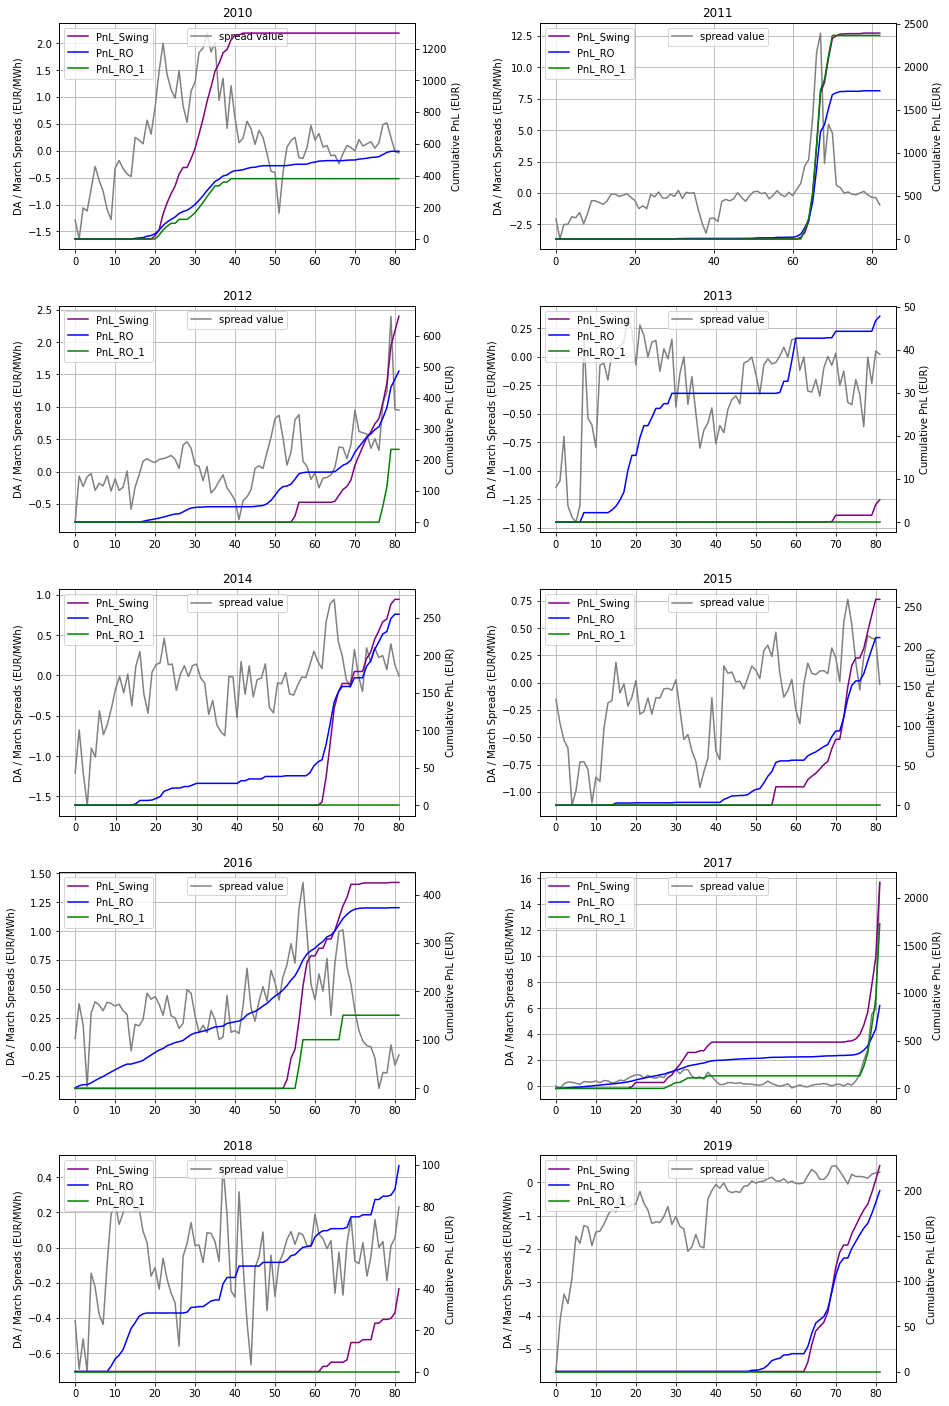

In [80]:
overall_graphs(list_df_performance_3)

In [81]:
df_perf_3 = overall_perf(list_df_performance_3, int(N3/2))
df_perf_3

,sto_year,PnL_swing,PnL_RO,PnL_RO_1,storage_usage,max_perf,perf_vs_max,RO_vs_max,RO_1_vs_max
0,2010,1297.7,552.7,380.4,100%,1350.5,96%,41%,28%
1,2011,2388.8,1720.0,2362.0,60%,2512.5,95%,68%,94%
2,2012,663.5,486.6,234.5,92%,797.5,83%,61%,29%
3,2013,5.2,47.8,0.0,20%,127.0,4%,38%,0%
4,2014,274.6,254.8,0.0,75%,352.3,78%,72%,0%
5,2015,259.1,211.0,0.0,90%,315.5,82%,67%,0%
6,2016,424.9,372.9,151.0,62%,767.0,55%,49%,20%
7,2017,2158.5,868.2,1726.5,98%,2312.2,93%,38%,75%
8,2018,40.0,99.6,0.0,55%,208.1,19%,48%,0%
9,2019,227.4,199.8,0.0,90%,242.0,94%,83%,0%


In [82]:
print('Cumulative fictive maximum PnL over 10 years :', df_perf_3['max_perf'].sum().round(0))

Cumulative fictive maximum PnL over 10 years : 8985.0


In [83]:
overall_performance_max = df_perf_3['PnL_swing'].sum() / df_perf_3['max_perf'].sum()
print('overall Swing algo performance vs. fictive maximum PnL over 10 years :', '{0:.0%}'.format(overall_performance_max))

overall Swing algo performance vs. fictive maximum PnL over 10 years : 86%


In [84]:
overall_RO_vs_max = df_perf_3['PnL_RO'].sum() / df_perf_3['max_perf'].sum()
print('overall Real Option strategy vs. fictive maximum PnL over 10 years :', '{0:.0%}'.format(overall_RO_vs_max))

overall Real Option strategy vs. fictive maximum PnL over 10 years : 54%


In [85]:
overall_RO_1_vs_max = df_perf_3['PnL_RO_1'].sum() / df_perf_3['max_perf'].sum()
print('overall Real Option 1 EUR strategy vs. fictive maximum PnL over 10 years :', '{0:.0%}'.format(overall_RO_1_vs_max))

overall Real Option 1 EUR strategy vs. fictive maximum PnL over 10 years : 54%


Overall Swing Algo with 10% threshold strategy has excellent results with 86% of fictive maximum PnL. 

However, we can compare those results individually with 5.2 and observe that only year 2017 is enhanced by the 10% threshold method. To really understand if there is a profit using this strategy, we would probable need more historical data to perfomr better analysis.

## 6 - Conclusion

In this paper, we have defined the role of a storage asset and the interest of optimizing its extrinsic value. 

We have explained how a storage asset optimization can be represented as a real swing option asset in order to optimize its value. For Swing option valuation, we have used the Extended Least-Square Monte-Carlo Algorithm applied to swing option as described in [2].

To run this Monte-Carlo algorithm, we have created simulated paths according to our convenient two-factor price model as described in [1], designed for energy commodities.

We have first compared the swing option algorithm for slow storage assets with fast storage asset: it is easy to understand that our algorithm has good results for slow storage assets although there is only little maximum profit to gain. 

The most interesting case is the fast storage asset (withdrawal in 20 days in our case). It is interesting to notice that overall performance is largely improved by our successive swing strategies:

* overall Real Option strategies both reach 54% of fictive maximum PnL
* overall Swing Algo strategy reaches 76% of fictive maximum PnL
* overall Swing Algo with 10% threshold strategy reaches **86% of fictive maximum PnL**

The last strategy is actually outperforming our expectations and this is really promising for future winter seasons.

#### Future perspectives and works

As the division into 2 exercise rights is definitely outperforming the simple swing option algorithm, it would be mathematically stimulating to try and 'infinitely' divide the number of exercise rights per trading day. Indeed, this could allow the user to decide not only whether to withdraw or not, but also the exact optimum volume to withdraw.



### References

[1] Modelling spot and forward prices for energy companies, Dafydd Steele, 2010.

[2] Pricing swing options in the electricity market, Caroline Olofsson, 2015
